In [21]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import sys
import random
from datetime import datetime
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import wandb

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# local imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from dcgan.utils.config import read_config
from dcgan.model.generator import Generator
from dcgan.model.discriminator import Discriminator
from dcgan.utils.layer_funcs import weights_init

In [28]:
config = read_config("./../config")

In [5]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [6]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and config.model.hyperparameters.ngpu > 0) else "cpu")

In [7]:
# Create the dataset
dataset = dset.ImageFolder(root=config.data.dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(config.data.image_size),
                               transforms.CenterCrop(config.data.image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=config.model.hyperparameters.batch_size,
                                         shuffle=True, 
                                         num_workers=config.data.workers
                                         )

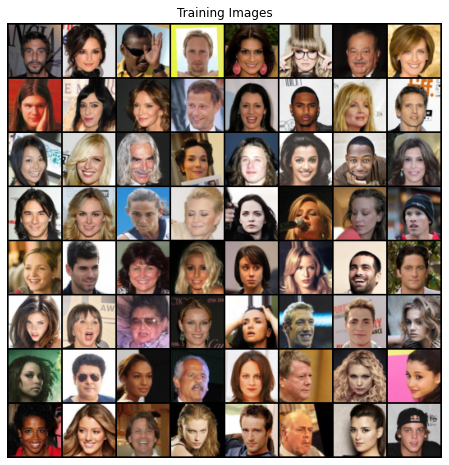

In [19]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [32]:
# Create the generator
netG = Generator(config).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (config.model.infra.ngpu > 1):
    netG = nn.DataParallel(netG, list(range(config.model.infra.ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (generator_net): Sequential(
    (convt1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (batchn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (convt2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (convt3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (convt4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=True)
    (convt5): ConvTranspose2d(64, 3, kernel_size=(4,

In [33]:
# Create the Discriminator
netD = Discriminator(config).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (config.model.infra.ngpu > 1):
    netD = nn.DataParallel(netD, list(range(config.model.infra.ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (discriminator_net): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rel4): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias

In [34]:
# Weights and Biases
wandb_config = {
  "learning_rate": config.model.hyperparameters.lr,
  "epochs": config.model.hyperparameters.num_epochs,
  "batch_size": config.model.hyperparameters.batch_size,
  "latent_vector_size": config.model.hyperparameters.nz,
  "generator_feature_map_size": config.model.hyperparameters.ngf,
  "discriminator_feature_map_size": config.model.hyperparameters.ndf,
}
wandb.init(project="dcgan-pytorch-1", entity="janmonko", config=config)

now = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"dcgan_pytorch_{now}"
wandb.run.name = run_name

# wandb.watch(netG, log="all", log_freq=config.wandb.log_freq)
wandb.watch(netG, log="all", log_freq=config.wandb.log_freq, idx=0)
wandb.watch(netD, log="all", log_freq=config.wandb.log_freq, idx=1)

[]

In [35]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, config.model.hyperparameters.nz, 1, 1, device=device)
fixed_noise_small = torch.randn(16, config.model.hyperparameters.nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=config.model.hyperparameters.lr, betas=(config.model.hyperparameters.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=config.model.hyperparameters.lr, betas=(config.model.hyperparameters.beta1, 0.999))

## Training

#### Optional loading from checkpoint

In [44]:
if config.general.checkpoint.start_from_checkpoint:
    checkpoint = torch.load(Path(config.general.checkpoint.path) / config.general.checkpoint.version)
    prev_epoch = checkpoint['epoch']
    netD.load_state_dict(checkpoint['discriminator_state_dict'])
    netG.load_state_dict(checkpoint['generator_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizer_disc_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizer_gen_state_dict'])
    errG = checkpoint['g_loss']
    errD = checkpoint['d_loss']
else:
    prev_epoch = -1

In [46]:
assert(prev_epoch < config.model.hyperparameters.num_epochs)

#### Training loop

In [51]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(prev_epoch+1, config.model.hyperparameters.num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, config.model.hyperparameters.nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, config.model.hyperparameters.num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == config.model.hyperparameters.num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        # WandB log
        if (iters % 10 == 0):
            with torch.no_grad():
                fake_small = netG(fixed_noise_small).detach().cpu()
                fake_small_wandb = [wandb.Image(image) for image in fake_small]
                wandb.log({"Examples": fake_small_wandb}, commit=False)
        
        wandb.log({"G_losses": errG.item(),
                   "D_losses": errD.item()
                   },
                  commit=True
                  )

        iters += 1
    # save checkpoint
    torch.save({
            'epoch': epoch,
            
            'discriminator_state_dict': netD.state_dict(),
            'generator_state_dict': netG.state_dict(),
            'optimizer_disc_state_dict': optimizerD.state_dict(),
            'optimizer_gen_state_dict': optimizerG.state_dict(),
            'g_loss': errG,
            'd_loss': errD,
            }, Path(config.general.checkpoint.path) / f"{run_name}.pt")
        
print("Training: It is a finish!")

Starting Training Loop...
[1/2][0/1583]	Loss_D: 0.3444	Loss_G: 3.9731	D(x): 0.8709	D(G(z)): 0.1562 / 0.0309
[1/2][50/1583]	Loss_D: 1.1764	Loss_G: 5.1627	D(x): 0.9486	D(G(z)): 0.6009 / 0.0135
[1/2][100/1583]	Loss_D: 0.7945	Loss_G: 2.7505	D(x): 0.5698	D(G(z)): 0.0484 / 0.1094
[1/2][150/1583]	Loss_D: 0.4710	Loss_G: 4.7266	D(x): 0.9014	D(G(z)): 0.2643 / 0.0164
[1/2][200/1583]	Loss_D: 0.4708	Loss_G: 3.3787	D(x): 0.7047	D(G(z)): 0.0245 / 0.0624
[1/2][250/1583]	Loss_D: 0.3656	Loss_G: 3.4202	D(x): 0.8244	D(G(z)): 0.1283 / 0.0481
[1/2][300/1583]	Loss_D: 0.3576	Loss_G: 3.6015	D(x): 0.7892	D(G(z)): 0.0623 / 0.0494
[1/2][350/1583]	Loss_D: 1.5076	Loss_G: 8.9452	D(x): 0.9487	D(G(z)): 0.6963 / 0.0003
[1/2][400/1583]	Loss_D: 0.6938	Loss_G: 4.9294	D(x): 0.9304	D(G(z)): 0.3990 / 0.0124
[1/2][450/1583]	Loss_D: 0.4128	Loss_G: 4.9318	D(x): 0.9275	D(G(z)): 0.2569 / 0.0119
[1/2][500/1583]	Loss_D: 0.7639	Loss_G: 1.4452	D(x): 0.5743	D(G(z)): 0.0543 / 0.2908
[1/2][550/1583]	Loss_D: 0.6514	Loss_G: 4.3653	D(x): 0

wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (Connect

## Visualizations

#### Exploring latent space

In [ ]:
# start from a random point ad move small steps from there, save each vector and generate image from it
# can walk in straight line, growing circles or random walk

#### Evolution and comparison to real

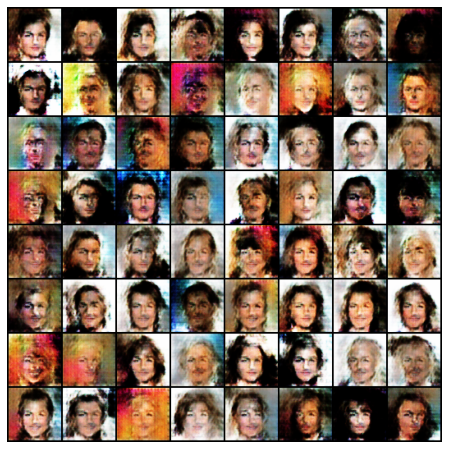

In [14]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

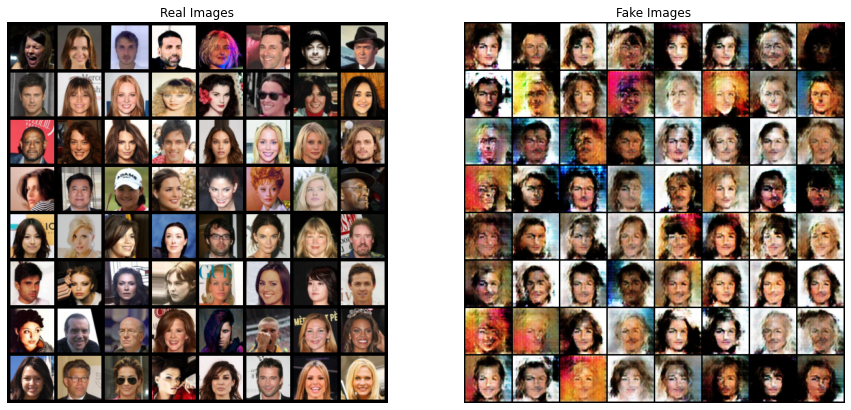

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()